# Finetuning Segment Anything with `µsam`

This notebook shows how to use Segment Anything for Microscopy to fine-tune a Segment Anything Model (SAM) on your custom data.

We use DIC microscopy images from the Cell Tracking Challenge, DIC-C2DH-HeLa, HeLa cells on a flat glass (from [Maška et al.](https://www.nature.com/articles/s41592-023-01879-y)) in this notebook. The functionalities shown here should work for your (microscopy) images too.

## Running this notebook

If you have an environment with `µsam` on your computer you can run this notebook in there. You can follow the [installation instructions](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation) to install it on your computer.

You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next cells will take care of the installation for you if you are using it.

In [1]:
# Check if we are running this notebook on kaggle, google colab or local compute resources.

import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

elif current_spot.startswith("/content"):
    print("Google Colab says hi!")
    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
    root_dir = "/content"

    # You might need to install condacolab on Google Colab to be able to install packages using conda / mamba
    # !pip install -q condacolab
    # import condacolab
    # condacolab.install()

else:
    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
    print(msg)
    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

Kaggle says hi!


### Installation

The next cells will install the `micro_sam` library on Kaggle Notebooks. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer.**

In [2]:
!git clone --quiet https://github.com/computational-cell-analytics/micro-sam.git
tmp_dir = os.path.join(root_dir, "micro-sam")
!pip install --quiet $tmp_dir

In [3]:
!git clone --quiet https://github.com/constantinpape/torch-em.git
tmp_dir = os.path.join(root_dir, "torch-em")
!pip install --quiet $tmp_dir

In [4]:
!git clone --quiet https://github.com/constantinpape/elf.git
tmp_dir = os.path.join(root_dir, "elf")
!pip install --quiet $tmp_dir

Known Issues on **Kaggle Notebooks**:

1. `warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program` (multiples lines of such warnings)
    - We have received this warning while testing this notebook on Kaggle. It does not lead to any issues while making use of the installed packages. You can proceed and ignore the warnings.

In [5]:
!mamba install -q -y -c conda-forge nifty affogato zarr z5py
!pip uninstall -y --quiet qtpy  # qtpy is not supported in Kaggle / Google Colab, let's remove it to avoid errors.

warning  libmamba Cache file "/opt/conda/pkgs/cache/497deca9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/09cdf8bf.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c6f2354e.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/86b0f08d.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c9ddbd6b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/b121c3e7.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/47929eba.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/3e39a7aa.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/4ea078d6.json" was modified by another program
Preparing 

### Importing the libraries

In [6]:
from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch

import torch_em
from torch_em.util.debug import check_loader
from torch_em.util.util import get_random_colors
from torch_em.transform.label import PerObjectDistanceTransform

from micro_sam import util
import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.instance_segmentation import (
    InstanceSegmentationWithDecoder,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)

2024-07-31 12:22:41.944738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 12:22:41.944867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 12:22:42.081029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Let's download the dataset

In [7]:
DATA_FOLDER = os.path.join(root_dir, "data")
os.makedirs(DATA_FOLDER, exist_ok=True)

# This will download the image and segmentation data for training.
image_dir = fetch_tracking_example_data(DATA_FOLDER)
segmentation_dir = fetch_tracking_segmentation_data(DATA_FOLDER)

100%|█████████████████████████████████████| 41.5M/41.5M [00:00<00:00, 31.6GB/s]
Extracting 'DIC-C2DH-HeLa/01/t000.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t001.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t002.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t003.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t004.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t005.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t006.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/

Example data directory is: /kaggle/working/data


100%|████████████████████████████████████████| 725k/725k [00:00<00:00, 778MB/s]
Extracting 'masks/mask_0000.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0001.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0002.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0003.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0004.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0005.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0006.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Ext

### Let's create the dataloaders

Our task is to segment HeLa cells on a flat glass in DIC microscopic images. The dataset comes from https://celltrackingchallenge.net/2d-datasets/, and the dataloader has been implemented in [torch-em](https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/ctc.py).

#### First, let's visualize how our samples look.

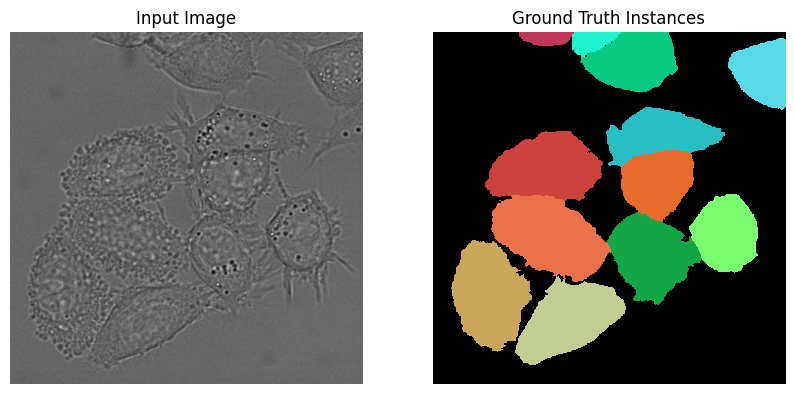

In [8]:
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")
    
    plt.show()
    plt.close()
    
    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders

In [9]:
# torch_em.default_segmentation_loader is a convenience function to build a torch dataloader
# from image data and labels for training segmentation models.
# It supports image data in various formats. Here, we load image data and labels from the two
# folders with tif images that were downloaded by the example data functionality, by specifying
# `raw_key` and `label_key` as `*.tif`. This means all images in the respective folders that end with
# .tif will be loadded.
# The function supports many other file formats. For example, if you have tif stacks with multiple slices
# instead of multiple tif images in a foldder, then you can pass raw_key=label_key=None.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md

# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Alternative: if you have tif stacks you can just set raw_key and label_key to None
# raw_key, label_key= None, None

# The 'roi' argument can be used to subselect parts of the data.
# Here, we use it to select the first 70 images (frames) for the train split and the other frames for the val split.
train_roi = np.s_[:70, :, :]
val_roi = np.s_[70:, :, :]

In [11]:
# The script below returns the train or val data loader for finetuning SAM.

# The data loader must be a torch data loader that returns `x, y` tensors,
# where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `torch_em.default_segmentation_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (1, 512, 512)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
train_instance_segmentation = True

# Label transform is used to convert the ground-truth labels to the desired instances for finetuning Segment Anything.
# or, to learn the foreground and distances to the object centers and object boundaries for automatic segmentation.
if train_instance_segmentation:
    # Computes the distance transform for objects to jointly perform the additional decoder-based automatic instance segmentation (AIS) and finetune Segment Anything.
    label_transform = PerObjectDistanceTransform(
        distances=True,
        boundary_distances=True,
        directed_distances=False,
        foreground=True,
        instances=True,
        min_size=25
    )
else:
    # Ensures the individual object instances.to finetune the clasiscal Segment Anything.
    label_transform = torch_em.transform.label.connected_components

train_loader = torch_em.default_segmentation_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=train_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)
val_loader = torch_em.default_segmentation_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=val_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)

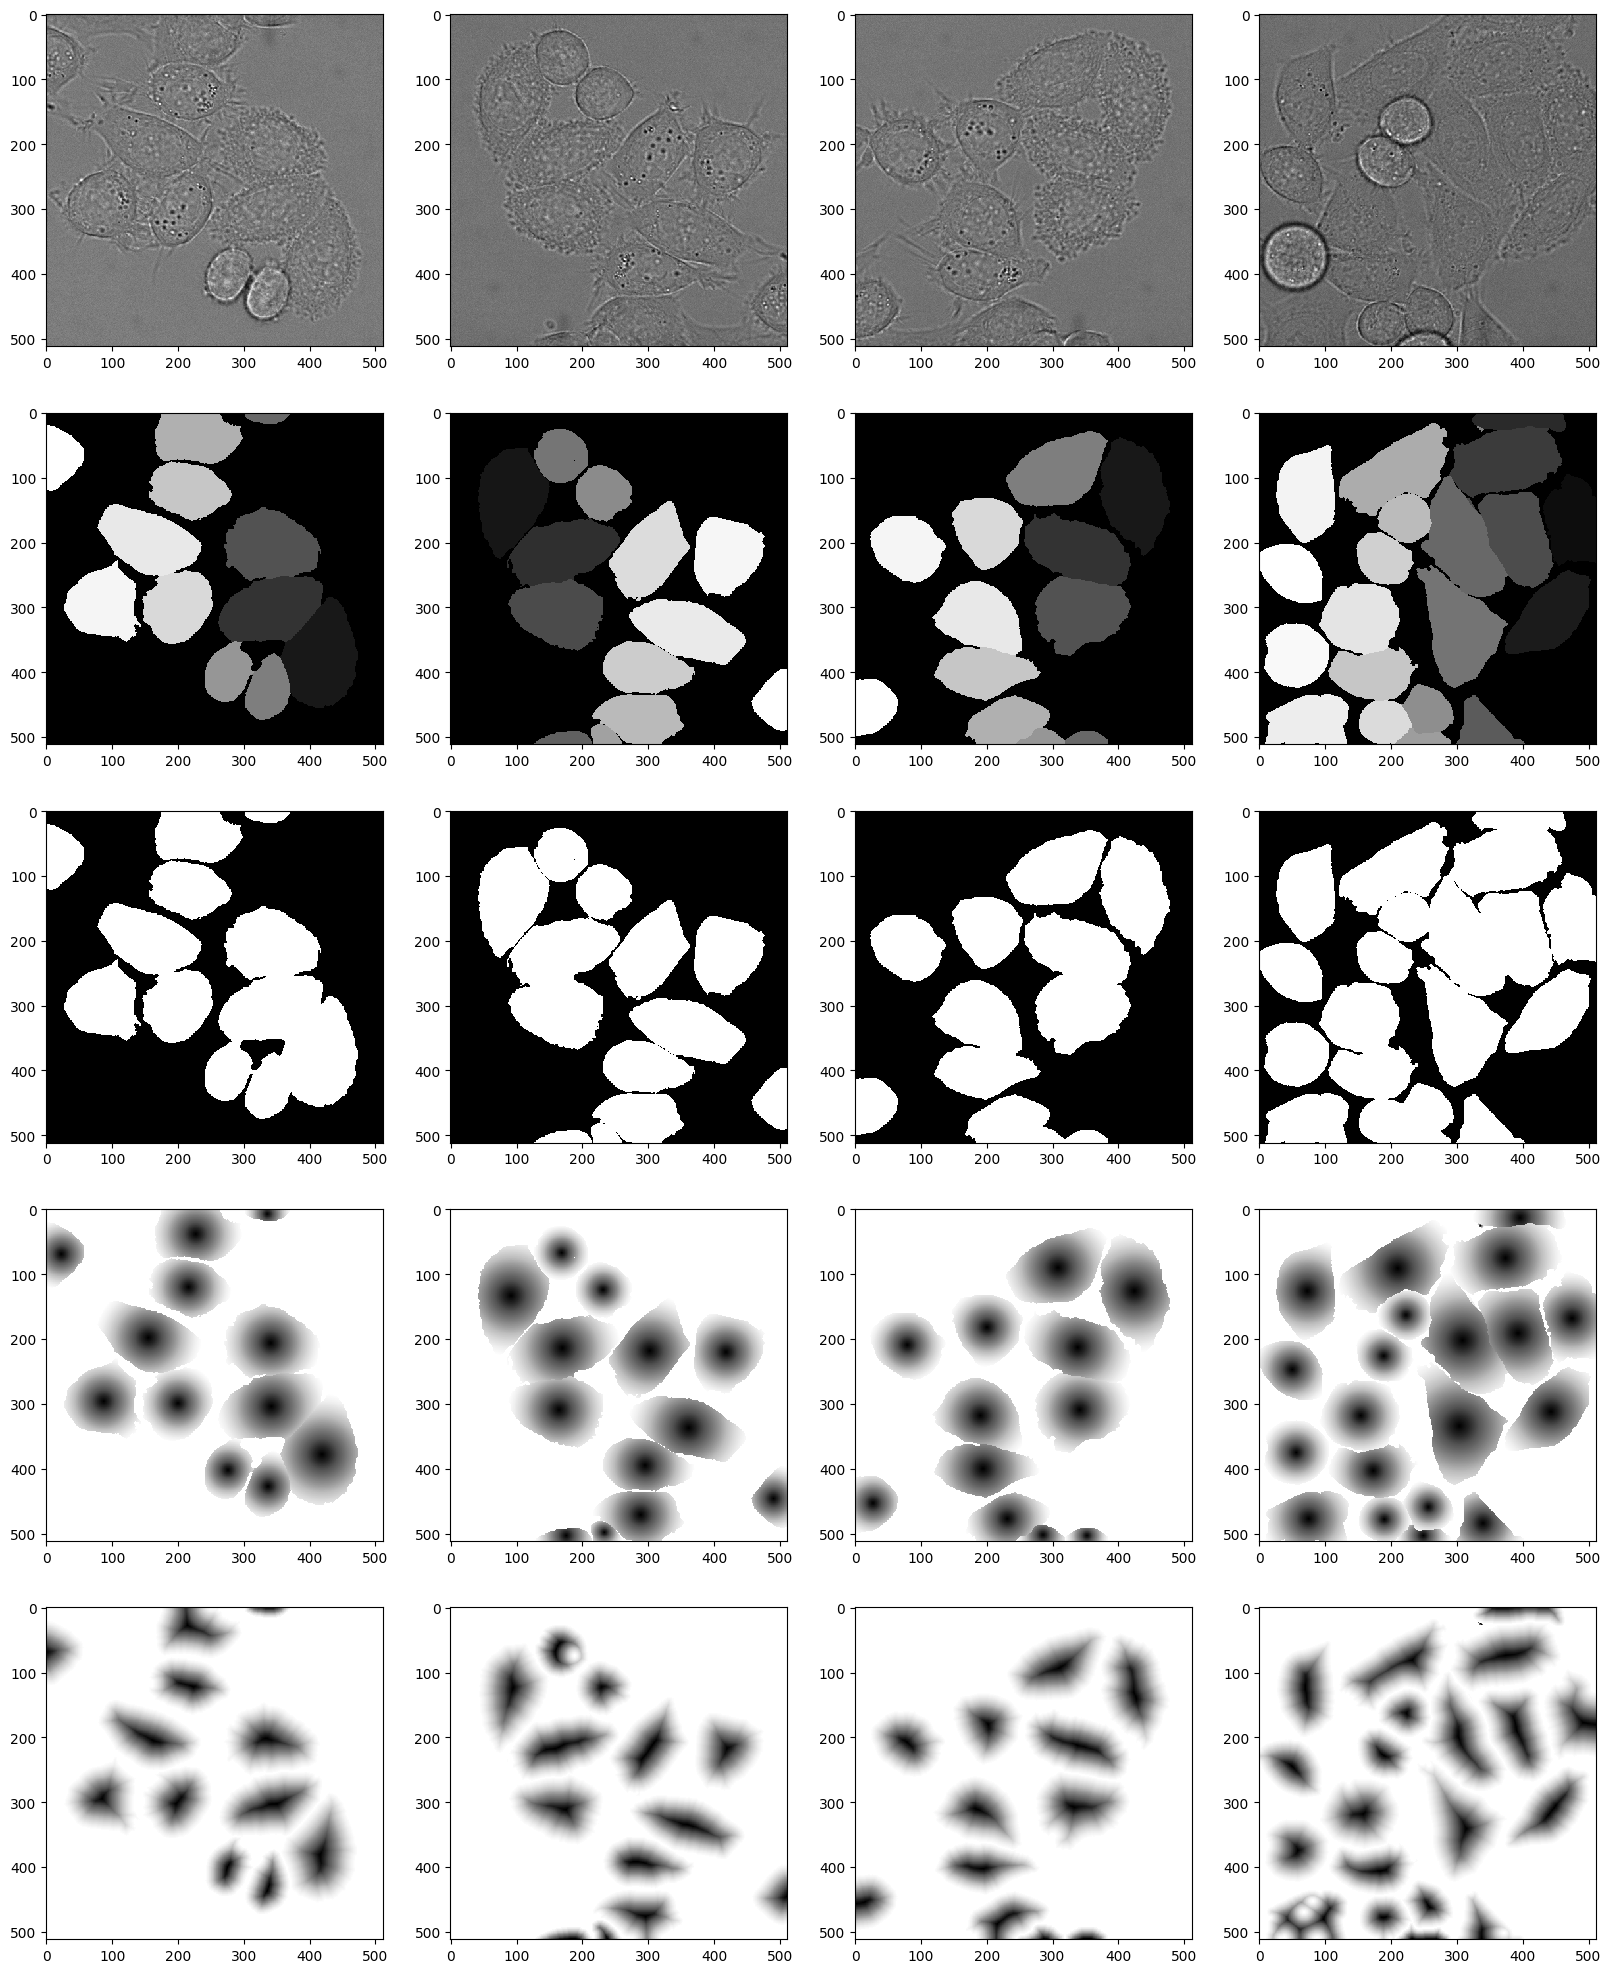

In [12]:
# Let's check how our samples look from the dataloader
check_loader(train_loader, 4, plt=True)

### Run the actual model finetuning

In [13]:
# All hyperparameters for training.
n_objects_per_batch = 5  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 10  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_hela"

**NOTE**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

In [14]:
# Run training
sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(root_dir, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 313GB/s]
/opt/conda/lib/python3.10/site-packages/torch_em/util/util.py:220: UserWarning: Constructor arguments for <class 'micro_sam.training.trainable_sam.TrainableSAM'> cannot be deduced.
For this object, empty constructor arguments will be used.
The trainer can probably not be correctly deserialized via 'DefaultTrainer.from_checkpoint'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch_em/util/util.py:220: UserWarning: Constructor arguments for <class 'torch_em.model.unetr.UNETR'> cannot be deduced.
For this object, empty constructor arguments will be used.
The trainer can probably not be correctly deserialized via 'DefaultTrainer.from_checkpoint'.
  warnings.warn(


Start fitting for 700 iterations /  10 epochs
with 70 iterations per epoch
Training with mixed precision


Epoch 10: average [s/it]: 2.350085, current metric: 0.086071, best metric: 0.075942: 100%|█████████▉| 699/700 [30:32<00:02,  2.62s/it] 

Finished training after 10 epochs / 700 iterations.
The best epoch is number 6.
Training took 1845.7220876216888 seconds (= 00:30:46 hours)


In [20]:
# Let's spot our best checkpoint and download it to get started with the annotation tool
best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")

# # Download link is automatically generated for the best model.
print("Click here \u2193")
FileLink(best_checkpoint)

Click here ↓


/kaggle/working/models/checkpoints/sam_hela/best.pt

### Let's run the automatic instance segmentation (AIS)

In [16]:
def run_automatic_instance_segmentation(image, checkpoint_path, model_type="vit_b_lm", device=None):
    """Automatic Instance Segmentation by training an additional instance decoder in SAM.

    NOTE: It is supported only for `µsam` models.
    
    Args:
        image: The input image.
        model_type: The choice of the `µsam` model.
        
    Returns:
        The instance segmentation.
    """
    # Step 1: Initialize the model attributes using the finetuned µsam model weights.
    #   - the 'predictor' object for generating predictions using the Segment Anything model.
    #   - the 'decoder' backbone (for AIS).
    predictor, decoder = get_predictor_and_decoder(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint_path=checkpoint_path,  # overwrite to pass our own finetuned model
        device=device,  # the device to run the model inference
    )
    
    # Step 2: Computation of the image embeddings from the vision transformer-based image encoder.
    image_embeddings = util.precompute_image_embeddings(
        predictor=predictor,  # the predictor object responsible for generating predictions
        input_=image,  # the input image
        ndim=2,  # number of input dimensions
    )
    
    # Step 3: Combining the decoder with the Segment Anything backbone for automatic instance segmentation.
    ais = InstanceSegmentationWithDecoder(predictor, decoder)
    
    # Step 4: Initializing the precomputed image embeddings to perform faster automatic instance segmentation.
    ais.initialize(
        image=image,  # the input image
        image_embeddings=image_embeddings,  # precomputed image embeddings
    )

    # Step 5: Getting automatic instance segmentations for the given image and applying the relevant post-processing steps.
    prediction = ais.generate()
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction

In [17]:
zip_path = os.path.join(root_dir, "data", "DIC-C2DH-HeLa-test.zip")
!wget http://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip -O $zip_path
    
trg_dir = os.path.join(root_dir, "data", "test")
os.makedirs(trg_dir, exist_ok=True)
!unzip $zip_path -d trg_dir

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-31 12:58:25--  http://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip
Resolving data.celltrackingchallenge.net (data.celltrackingchallenge.net)... 147.251.52.183
Connecting to data.celltrackingchallenge.net (data.celltrackingchallenge.net)|147.251.52.183|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip [following]
--2024-07-31 12:58:25--  https://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip
Connecting to data.celltrackingchallenge.net (data.celltrackingchallenge.net)|147.251.52.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42728352 (41M) [application/zip]
Saving to: '/kaggle/working/data/DIC-C2DH-HeLa-test.zip'

/kaggle/working/dat 100%[===================>]  40.75M  14.3MB/s    in 2.9s    

2024-07-31 12:58:29 (14.3 MB/s) - '/kaggle/working/data/DIC-C2DH-HeLa-test.zip' saved [42728352/42728352]

Archi

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


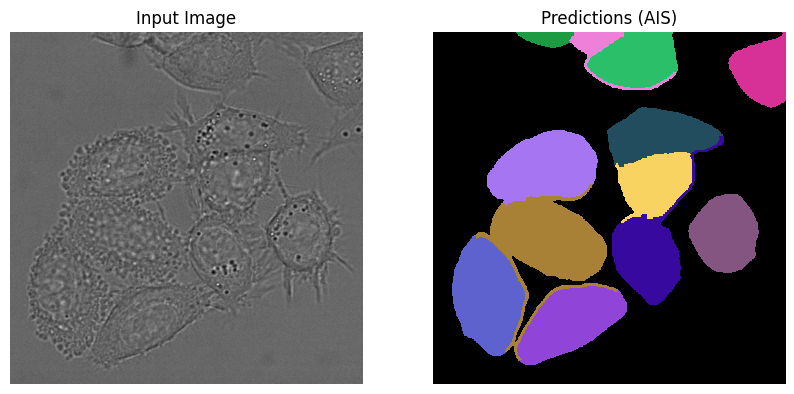

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


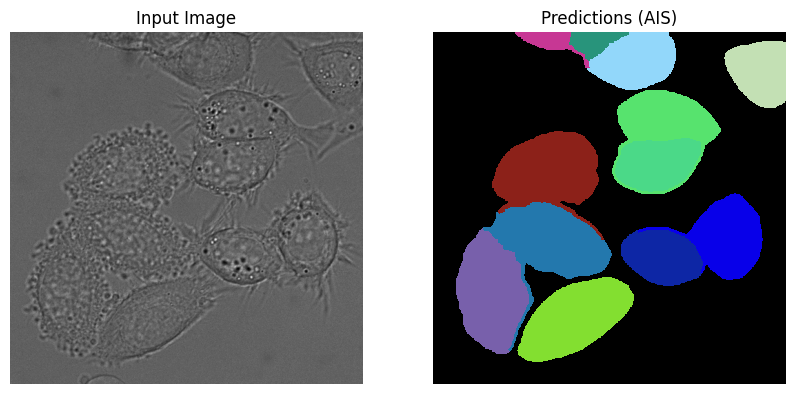

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


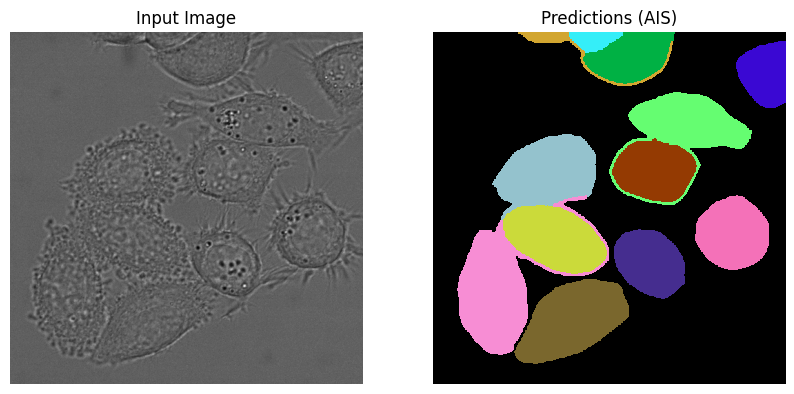

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


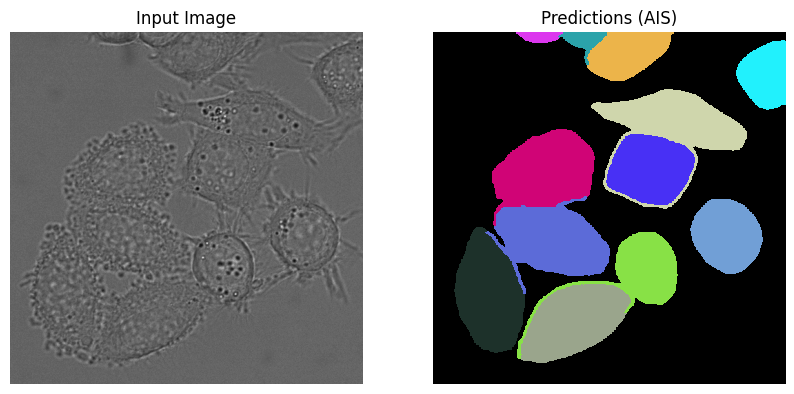

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


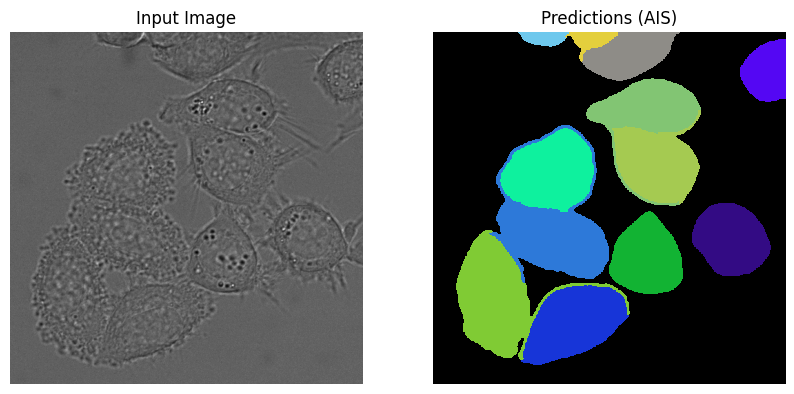

In [18]:
assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

# # Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
image_paths = image_paths[:5]

for image_path in image_paths:
    image = imageio.imread(image_path)
    
    # Predicted instances
    prediction = run_automatic_instance_segmentation(
        image=image,
        checkpoint_path=best_checkpoint,
        model_type=model_type,
        device=device
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(prediction, cmap=get_random_colors(prediction), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Predictions (AIS)")

    plt.show()
    plt.close()

### What next?

It's time to get started with your custom finetuned model using the annotator tool. Here is the documentation on how to get started with `µsam`: [Annotation Tools](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools)

Happy annotating!

*This notebook was last ran on July 31, 2024*